In [1]:
import sys
sys.path.append("\..")

In [2]:
from lava.proc.lif.process import LIF
from lava.lib.dnf.connect.connect import connect
from lava.lib.dnf.operations.operations import Weights
from lava.lib.dnf.kernels.kernels import MultiPeakKernel
from lava.lib.dnf.operations.operations import Convolution
from lava.lib.dnf.kernels.kernels import SelectiveKernel
from lava.proc.io.source import RingBuffer

In [3]:
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.lib.dnf.inputs.gauss_pattern.process import GaussPattern
from lava.lib.dnf.inputs.rate_code_spike_gen.process import RateCodeSpikeGen
from lava.proc.monitor.process import Monitor
import scipy.sparse


In [4]:
import matplotlib.pyplot as plt

In [5]:
import numpy as np
points = np.load("slider_01.npy")

In [6]:
points = points[::1]
points.shape

(5592,)

In [7]:
val_range=[0.0, 3.0]
n_levels = 300

In [8]:
input_data = np.zeros((points.shape[0], n_levels))

In [9]:
for i, p in enumerate(points):
    if np.isnan(p) or p<val_range[0] or p>=val_range[1]:
        continue
    idx = int((n_levels / val_range[1]) * p)
#     print(idx)
    input_data[i, idx] = 1 
# input_data = input_data.transpose()
print(input_data.shape)

(5592, 300)


(0.0, 300.0)

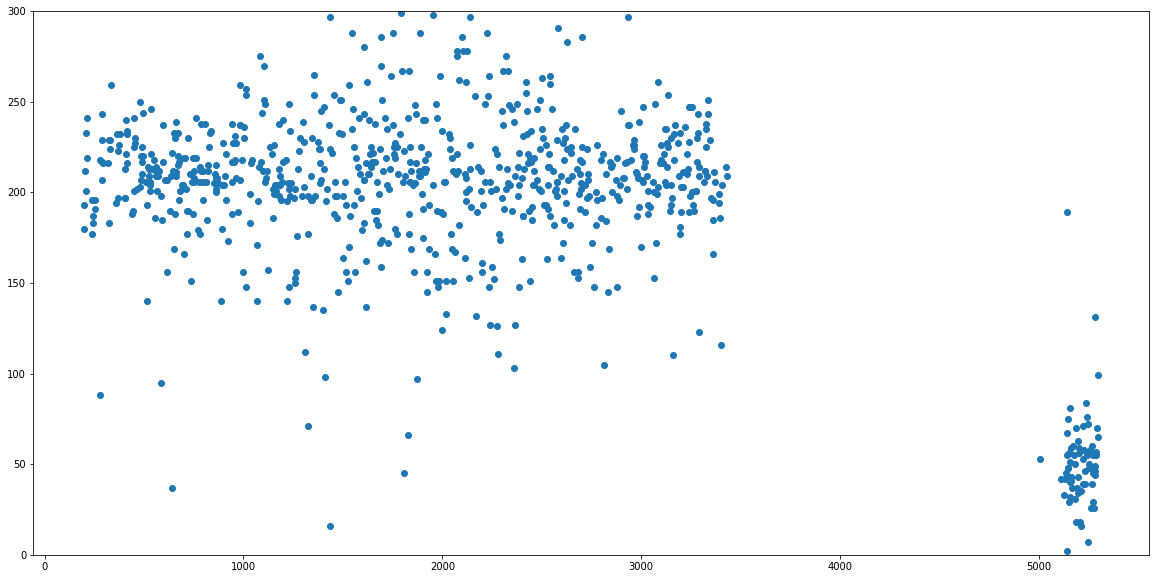

In [10]:

test = input_data
data_s = scipy.sparse.csr_matrix(test[:])

t_in, v_in, _ = scipy.sparse.find(data_s)

plt.figure(figsize=(20, 10))
plt.scatter(t_in, v_in)
# plt.axhline(20, c="red")
plt.ylim([0, 300])

In [11]:
input_data = input_data.transpose()
input_data.shape

(300, 5592)

In [12]:
input_proc = RingBuffer(input_data)

In [13]:
dnf = LIF(shape=(n_levels,), du=0.11, dv=0.5, vth=10)

kernel = SelectiveKernel(amp_exc=4.0,
                         width_exc=20.0,
                         global_inh=-3)
# kernel = MultiPeakKernel(amp_exc=12,
#                          width_exc=15,
#                          amp_inh=-8,
#                          width_inh=40)
connect(dnf.s_out, dnf.a_in, [Convolution(kernel)])
connect(input_proc.s_out, dnf.a_in, [Weights(7)])

In [14]:
# Set up a monitor and probe the spike output of the DNF
time_steps = points.shape[0]
monitor = Monitor()
monitor.probe(dnf.s_out, time_steps)

monitor_v = Monitor()
monitor_v.probe(dnf.v, time_steps)

monitor_u = Monitor()
monitor_u.probe(dnf.u, time_steps)

# Run the DNF
dnf.run(condition=RunSteps(num_steps=time_steps),
        run_cfg=Loihi1SimCfg(select_tag='floating_pt'))

# Get probed data from monitor
probed_data = monitor.get_data()
# probed_data_v = monitor_v.get_data()
# probed_data_u = monitor_u.get_data()

# Stop the execution after getting the monitor's data
dnf.stop()

In [15]:
data = probed_data[dnf.name][dnf.s_out.name]

In [16]:
probed_data

{'Process_1': {'s_out': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])}}

In [17]:
data.shape

(5592, 300)

In [18]:
probed_data

{'Process_1': {'s_out': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]])}}

In [19]:
data_s = scipy.sparse.csr_matrix(data)

In [20]:
t_out, v_out, _ = scipy.sparse.find(data_s)

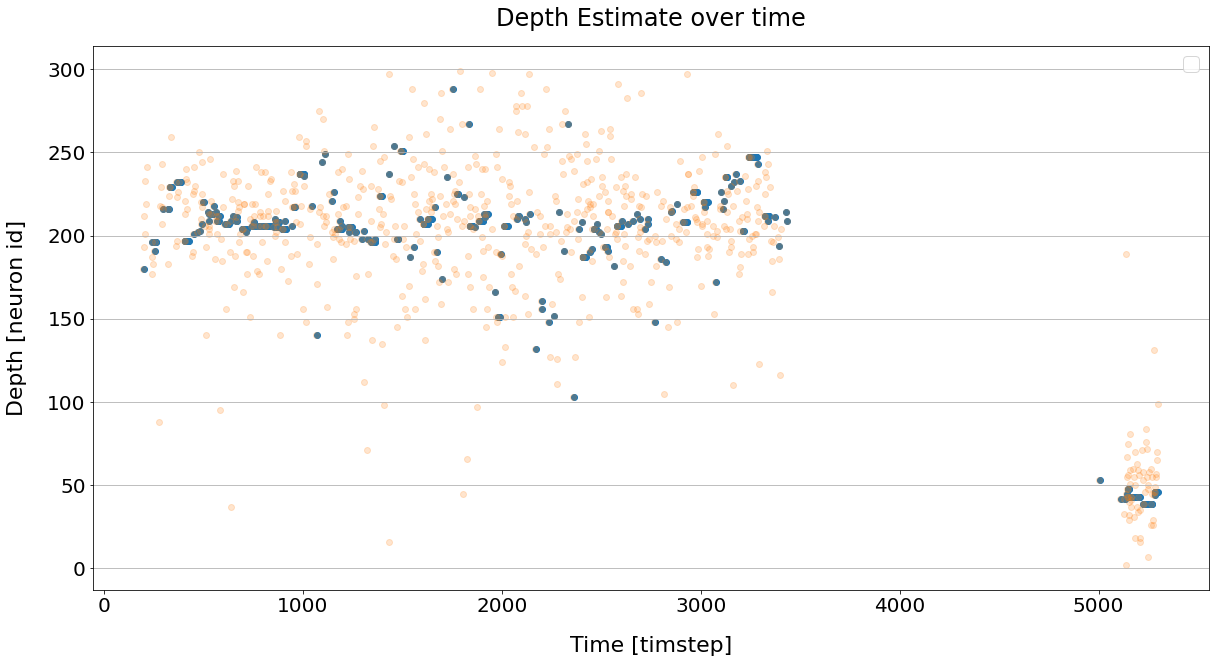

In [21]:
plt.figure(figsize=(20, 10))
plt.scatter(t_out, v_out)
plt.scatter(t_in, v_in, alpha=0.2)
plt.legend(fontsize=20)
plt.xlabel("Time [timstep]", fontsize=22, labelpad=20)
plt.ylabel("Depth [neuron id]", fontsize=22, labelpad=20)
plt.title("Depth Estimate over time", fontsize=24, pad=20)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
# plt.ylim([160, 200])
# print(results.times[1226])
plt.grid(axis="y")

In [22]:
# test = input_data.transpose()
# data_s = scipy.sparse.csr_matrix(test[:])

# t, v, _ = scipy.sparse.find(data_s)

# plt.figure(figsize=(20, 10))
# plt.scatter(t, v / 100)
# plt.axhline(2.0, c="red")
# plt.axhline(1.4, c="red")
# # plt.ylim([1.0, 2.5])

In [23]:
probed_data_v

NameError: name 'probed_data_v' is not defined

In [ ]:
data_v = probed_data_v["Process_1"]["v"]

In [ ]:
plt.plot(data_v[:, 180])

In [ ]:
data_v.shape

In [ ]:
data_u = probed_data_u["Process_1"]["u"]

In [ ]:
plt.plot(data_u[:, 180])

In [ ]:
kernel.weights

In [ ]:
plt.figure(figsize=(1, 20))
m = plt.imshow((kernel.weights.reshape(41, 1)))
plt.colorbar(m)